In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import math
import time
from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
df_1 = pd.read_csv('takehome_user_engagement.csv')

In [4]:
df_2 = pd.read_csv('takehome_users.csv')

In [5]:
df_1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
df_1['time_stamp'] = pd.to_datetime(df_1['time_stamp'])

In [8]:
df_1['wk'] = df_1['time_stamp'].dt.week
df_1['year'] = df_1['time_stamp'].dt.year
df_1['month'] = df_1['time_stamp'].dt.month
df_1['day'] = df_1['time_stamp'].dt.day

<ipython-input-8-4d594ffec820>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_1['wk'] = df_1['time_stamp'].dt.week


In [9]:
df_1 = df_1.drop(columns='time_stamp', axis = 1)

In [10]:
df_1.head()

,user_id,visited,wk,year,month,day
0,1,1,17,2014,4,22
1,2,1,46,2013,11,15
2,2,1,48,2013,11,29
3,2,1,50,2013,12,9
4,2,1,52,2013,12,25


In [11]:
df_1.duplicated().sum()

0

In [12]:
df_1 = pd.read_csv('takehome_user_engagement.csv')

In [13]:
df_1['time_stamp'] = pd.to_datetime(df_1['time_stamp'])
df_1['wk'] = df_1['time_stamp'].dt.week
df_1 = df_1.groupby(['wk','user_id'])['time_stamp'].count().reset_index(name = 'count').drop_duplicates()

<ipython-input-13-b879e8a41f51>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_1['wk'] = df_1['time_stamp'].dt.week


In [14]:
df_1['adopted_user'] = np.nan
df_1['adopted_user'] = np.where(df_1['count'] >= 3, 1, df_1['adopted_user'])
df_1['adopted_user'] = np.where(df_1['count'] <3, 0, df_1['adopted_user'])

In [15]:
df_1.head()

,wk,user_id,count,adopted_user
0,1,2,1,0.0
1,1,10,5,1.0
2,1,42,4,1.0
3,1,43,1,0.0
4,1,46,1,0.0


In [16]:
df_1 = df_1.rename(columns={"user_id": 'object_id'})

In [17]:
df = pd.merge(df_1, df_2, on = 'object_id')

In [18]:
df.head()

,wk,object_id,count,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2,1,0.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
1,2,2,1,0.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,6,2,3,1.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,7,2,2,0.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
4,10,2,1,0.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [19]:
df.adopted_user.value_counts()

1.0    29771
0.0    27401
Name: adopted_user, dtype: int64

In [20]:
df = df.drop(['object_id', 'count', 'name', 'email', 'wk'], axis = 1)

In [21]:
categorical_feat = ['creation_time', 'creation_source']

In [22]:
for feature in categorical_feat:
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(list(df[feature].values.astype('str')))
    df[feature] = label_encoder.transform(list(df[feature].values.astype('str'))) 
    print("for feature {0}: label-encoding was done succesfully".format(feature))

for feature creation_time: label-encoding was done succesfully
for feature creation_source: label-encoding was done succesfully


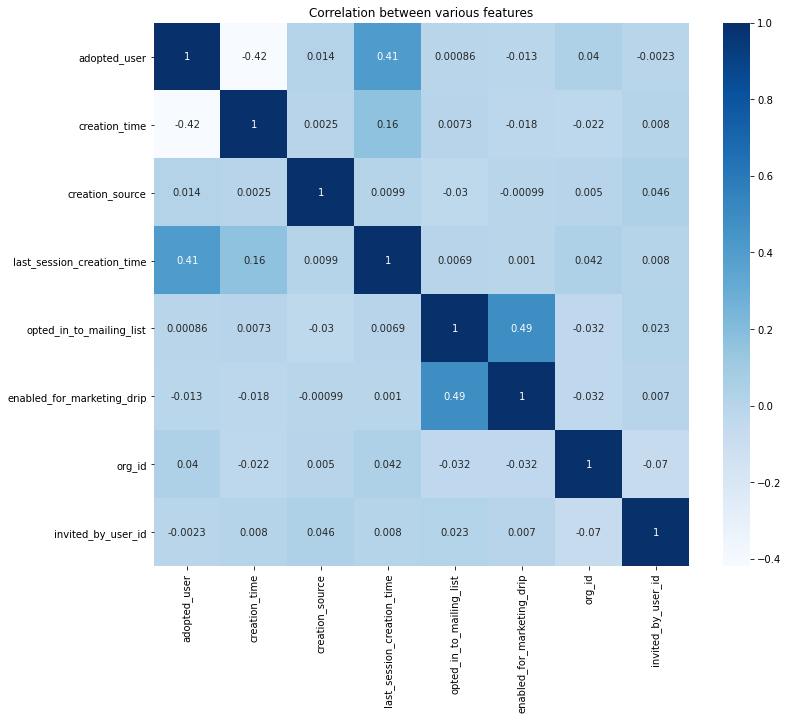

In [23]:
plt.figure(figsize=(12,10))
p=sns.heatmap(df.corr(), annot=True,cmap ='Blues')
plt.title('Correlation between various features');

In [24]:
df_0 = df[df['adopted_user']== 0]
df_1 = df[df['adopted_user']== 1]

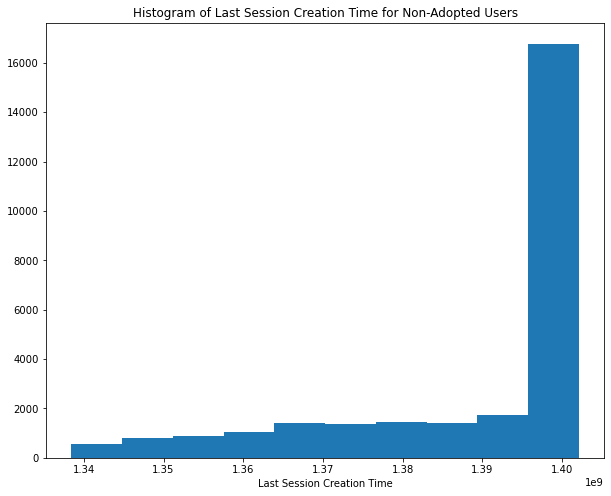

In [25]:
plt.figure(figsize=(10, 8))
plt.hist(df_0['last_session_creation_time'])
plt.title('Histogram of Last Session Creation Time for Non-Adopted Users')
plt.xlabel('Last Session Creation Time');

In [26]:
df_0['last_session_creation_time'].describe()

count    2.740100e+04
mean     1.389738e+09
std      1.720652e+07
min      1.338452e+09
25%      1.380156e+09
50%      1.400641e+09
75%      1.401620e+09
max      1.402067e+09
Name: last_session_creation_time, dtype: float64

In [27]:
df_1['last_session_creation_time'].describe()

count    2.977100e+04
mean     1.400824e+09
std      4.368932e+06
min      1.345699e+09
25%      1.401161e+09
50%      1.401697e+09
75%      1.401869e+09
max      1.401926e+09
Name: last_session_creation_time, dtype: float64

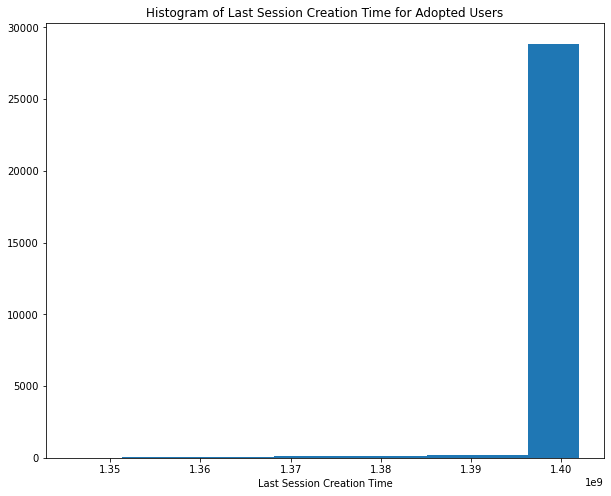

In [28]:
plt.figure(figsize=(10, 8))
plt.hist(df_1['last_session_creation_time'])
plt.title('Histogram of Last Session Creation Time for Adopted Users')
plt.xlabel('Last Session Creation Time');

In [29]:
df_0['creation_time'].min(),

(0,)

In [30]:
df_0['creation_time'].max()

8820

In [31]:
df_1['creation_time'].min()

12

In [32]:
df_1['creation_time'].max()

8468

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57172 entries, 0 to 57171
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopted_user                57172 non-null  float64
 1   creation_time               57172 non-null  int64  
 2   creation_source             57172 non-null  int64  
 3   last_session_creation_time  57172 non-null  float64
 4   opted_in_to_mailing_list    57172 non-null  int64  
 5   enabled_for_marketing_drip  57172 non-null  int64  
 6   org_id                      57172 non-null  int64  
 7   invited_by_user_id          32190 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.9 MB


In [34]:
df['adopted_user'].value_counts()

1.0    29771
0.0    27401
Name: adopted_user, dtype: int64

In [35]:
df['invited_by_user_id'] = df['invited_by_user_id'].replace(np.nan, 0)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57172 entries, 0 to 57171
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   adopted_user                57172 non-null  float64
 1   creation_time               57172 non-null  int64  
 2   creation_source             57172 non-null  int64  
 3   last_session_creation_time  57172 non-null  float64
 4   opted_in_to_mailing_list    57172 non-null  int64  
 5   enabled_for_marketing_drip  57172 non-null  int64  
 6   org_id                      57172 non-null  int64  
 7   invited_by_user_id          57172 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.9 MB


In [37]:
X = df.drop(columns='adopted_user', axis = 1)
y = df['adopted_user']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [39]:
model = LogisticRegression()

parameters = {'class_weight': ['balanced', None],
              'penalty' : ['l1', 'l2', 'none'],
              'C': np.arange(0.5, 20.0, 0.5),
              'fit_intercept': [True, False],
             'multi_class': ['auto','ovr','multinomial']}

In [40]:
lg_random = RandomizedSearchCV(estimator = model, param_distributions = parameters,
                               verbose = False, n_iter = 10, cv = 5, random_state=42, n_jobs = -1)
lg_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", lg_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67841079 0.52258871 0.52258871 0.67841079        nan        nan
 0.67841079 0.52258871 0.67841079        nan]
  warnings.warn(


 Results from Random Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=16.0, class_weight='balanced', fit_intercept=False)


In [41]:
y_pred = lg_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[5271 3024]
 [2574 6283]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.67      0.64      0.65      8295
         1.0       0.68      0.71      0.69      8857

    accuracy                           0.67     17152
   macro avg       0.67      0.67      0.67     17152
weighted avg       0.67      0.67      0.67     17152



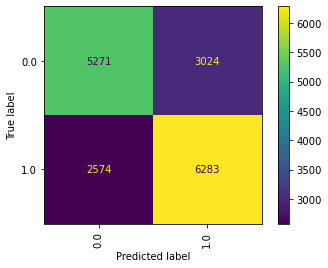

In [42]:
plot_confusion_matrix(lg_random, X_test, y_test,xticks_rotation='vertical')

In [43]:
lg_acc_score = accuracy_score(y_test, y_pred)
lg_pre_score = precision_score(y_test, y_pred)
lg_rec_score = recall_score(y_test, y_pred)
lg_f1_score = f1_score(y_test, y_pred)

In [44]:
model = DecisionTreeClassifier()

parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_leaf_nodes': [3,4,5,10,15,20,25,50,75,100,125,150,200, None]}

In [45]:
dt_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               random_state=42, n_jobs = -1)
dt_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", dt_random.best_estimator_)

 Results from Random Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(max_depth=50, max_features='sqrt', max_leaf_nodes=100,
                       min_samples_leaf=25, min_samples_split=100)


In [46]:
y_pred = dt_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[6039 2256]
 [1431 7426]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.81      0.73      0.77      8295
         1.0       0.77      0.84      0.80      8857

    accuracy                           0.79     17152
   macro avg       0.79      0.78      0.78     17152
weighted avg       0.79      0.79      0.78     17152



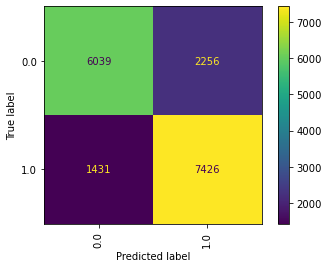

In [47]:
plot_confusion_matrix(dt_random, X_test, y_test,xticks_rotation='vertical')

In [48]:
dt_acc_score = accuracy_score(y_test, y_pred)
dt_pre_score = precision_score(y_test, y_pred)
dt_rec_score = recall_score(y_test, y_pred)
dt_f1_score = f1_score(y_test, y_pred)

In [49]:
model = RandomForestClassifier()

parameters = {'n_estimators': [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
              'criterion': ['gini', 'entropy'],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'min_weight_fraction_leaf': [0.01, 0.1, 0.25, 0.001, 0.5, 0.75, 0.9],
               'bootstrap': [True, False]}

In [50]:
rf_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.79002999        nan        nan 0.78925537        nan
 0.52258871        nan        nan 0.77378811]
  warnings.warn(


 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=200, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=700,
                       min_weight_fraction_leaf=0.01, n_estimators=35)


In [51]:
y_pred = rf_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[6284 2011]
 [1583 7274]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.80      0.76      0.78      8295
         1.0       0.78      0.82      0.80      8857

    accuracy                           0.79     17152
   macro avg       0.79      0.79      0.79     17152
weighted avg       0.79      0.79      0.79     17152



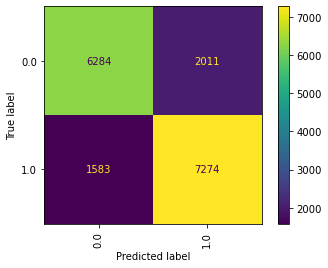

In [52]:
plot_confusion_matrix(rf_random, X_test, y_test,xticks_rotation='vertical')

In [53]:
rf_acc_score = accuracy_score(y_test, y_pred)
rf_pre_score = precision_score(y_test, y_pred)
rf_rec_score = recall_score(y_test, y_pred)
rf_f1_score = f1_score(y_test, y_pred)

In [54]:
model = MultinomialNB()

parameters = {"alpha":[0.001,0.005,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
                "fit_prior":[True,False]}

In [55]:
mnb_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
mnb_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", mnb_random.best_estimator_)

 Results from Random Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=0.3)


In [56]:
y_pred = mnb_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[5325 2970]
 [2622 6235]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.67      0.64      0.66      8295
         1.0       0.68      0.70      0.69      8857

    accuracy                           0.67     17152
   macro avg       0.67      0.67      0.67     17152
weighted avg       0.67      0.67      0.67     17152



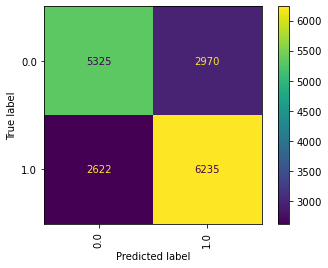

In [57]:
plot_confusion_matrix(mnb_random, X_test, y_test,xticks_rotation='vertical')

In [58]:
mnb_acc_score = accuracy_score(y_test, y_pred)
mnb_pre_score = precision_score(y_test, y_pred)
mnb_rec_score = recall_score(y_test, y_pred)
mnb_f1_score = f1_score(y_test, y_pred)

In [59]:
model = XGBClassifier()

parameters = {'n_estimators':[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.25, 0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'class_weight':[None,'balanced'],
          'max_depth': [1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
          'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3]
         }

In [60]:
xgb_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
xgb_random.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", xgb_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 Results from Random Search 

 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=150, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [61]:
y_pred = xgb_random.predict(X_test)
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Confusion matrix: 
 [[6535 1760]
 [1478 7379]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.82      0.79      0.80      8295
         1.0       0.81      0.83      0.82      8857

    accuracy                           0.81     17152
   macro avg       0.81      0.81      0.81     17152
weighted avg       0.81      0.81      0.81     17152



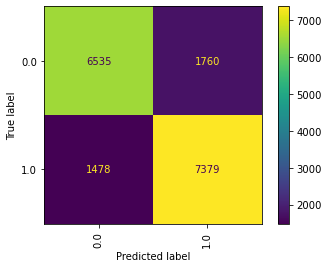

In [62]:
plot_confusion_matrix(xgb_random, X_test, y_test,xticks_rotation='vertical')

In [63]:
xgb_acc_score = accuracy_score(y_test, y_pred)
xgb_pre_score = precision_score(y_test, y_pred)
xgb_rec_score = recall_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)

In [64]:
# Creating a models table
model_selection=pd.DataFrame({'Model':['Logistic Regession', 'Decision Tree Classifier', 'Random Forest Classifier',
                                        'MultinomialNB', 'XGBClassifier'], 
                             'Accuracy Score':[lg_acc_score, dt_acc_score, rf_acc_score, mnb_acc_score, xgb_acc_score],
                             'Precision Score':[lg_pre_score, dt_pre_score, rf_pre_score, mnb_pre_score,xgb_pre_score],
                             'Recall Score':[lg_rec_score, dt_rec_score, rf_rec_score, mnb_rec_score, xgb_rec_score],
                             'F1 Score':[lg_f1_score, dt_f1_score, rf_f1_score, mnb_f1_score, xgb_f1_score]})

In [65]:
model_selection

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score
0,Logistic Regession,0.673624,0.675083,0.709382,0.691808
1,Decision Tree Classifier,0.785040,0.766990,0.838433,0.801122
2,Random Forest Classifier,0.790462,0.783414,0.821271,0.801896
3,MultinomialNB,0.673974,0.677349,0.703963,0.690400
4,XGBClassifier,0.811217,0.807419,0.833126,0.820071


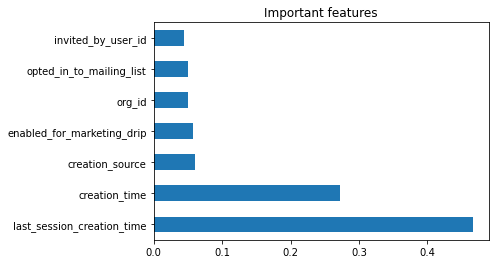

In [66]:
feat_importances = pd.Series(xgb_random.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Important features")
plt.show()